In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from tqdm import tqdm
from scipy import stats
import math 
import seaborn as sns




---------



# Question 1: How effective are vaccines?
Data source 1: 
https://ourworldindata.org/covid-deaths-by-vaccination
- Contains data about how many people had symptomatic courses(and hospilitation rate) per 100k split into vaccinated/unvaccinated/boostered
- I ignored the fact that the data depends on time because i didnt know how to handle with that

In [3]:
#read data and put it into format to work with
xls = pd.ExcelFile('Inzidenz_Impfstatus.xlsx')
xls.sheet_names

['Erläuterungen',
 'Symptomatische_nach_Impfstatus',
 'Hospitalisierte_nach_Impfstatus']

In [4]:
df1 = pd.read_excel('Inzidenz_Impfstatus.xlsx', sheet_name="Symptomatische_nach_Impfstatus",skiprows=3)
df2 = pd.read_excel('Inzidenz_Impfstatus.xlsx', sheet_name="Hospitalisierte_nach_Impfstatus",skiprows=3)

In [5]:
df1.columns = [c.replace(' ', '_') for c in df1.columns]
df1=df1.replace("--",0)
df2.columns = [c.replace(' ', '_') for c in df2.columns]
df2=df2.replace("--",0)

In [6]:
#split tables into groups with each 2 columns (vaccinated and unvaccinated)
da1=df1.iloc[:,[2,3,4,5,7,8]]
da2=df2.iloc[:,[2,3,4,5,7,8]]
symp=np.array_split(np.array(da1.columns),3)
hosp=np.array_split(np.array(da2.columns),3)
hosp[0][0]

'Ungeimpfte_12-17_Jahre'

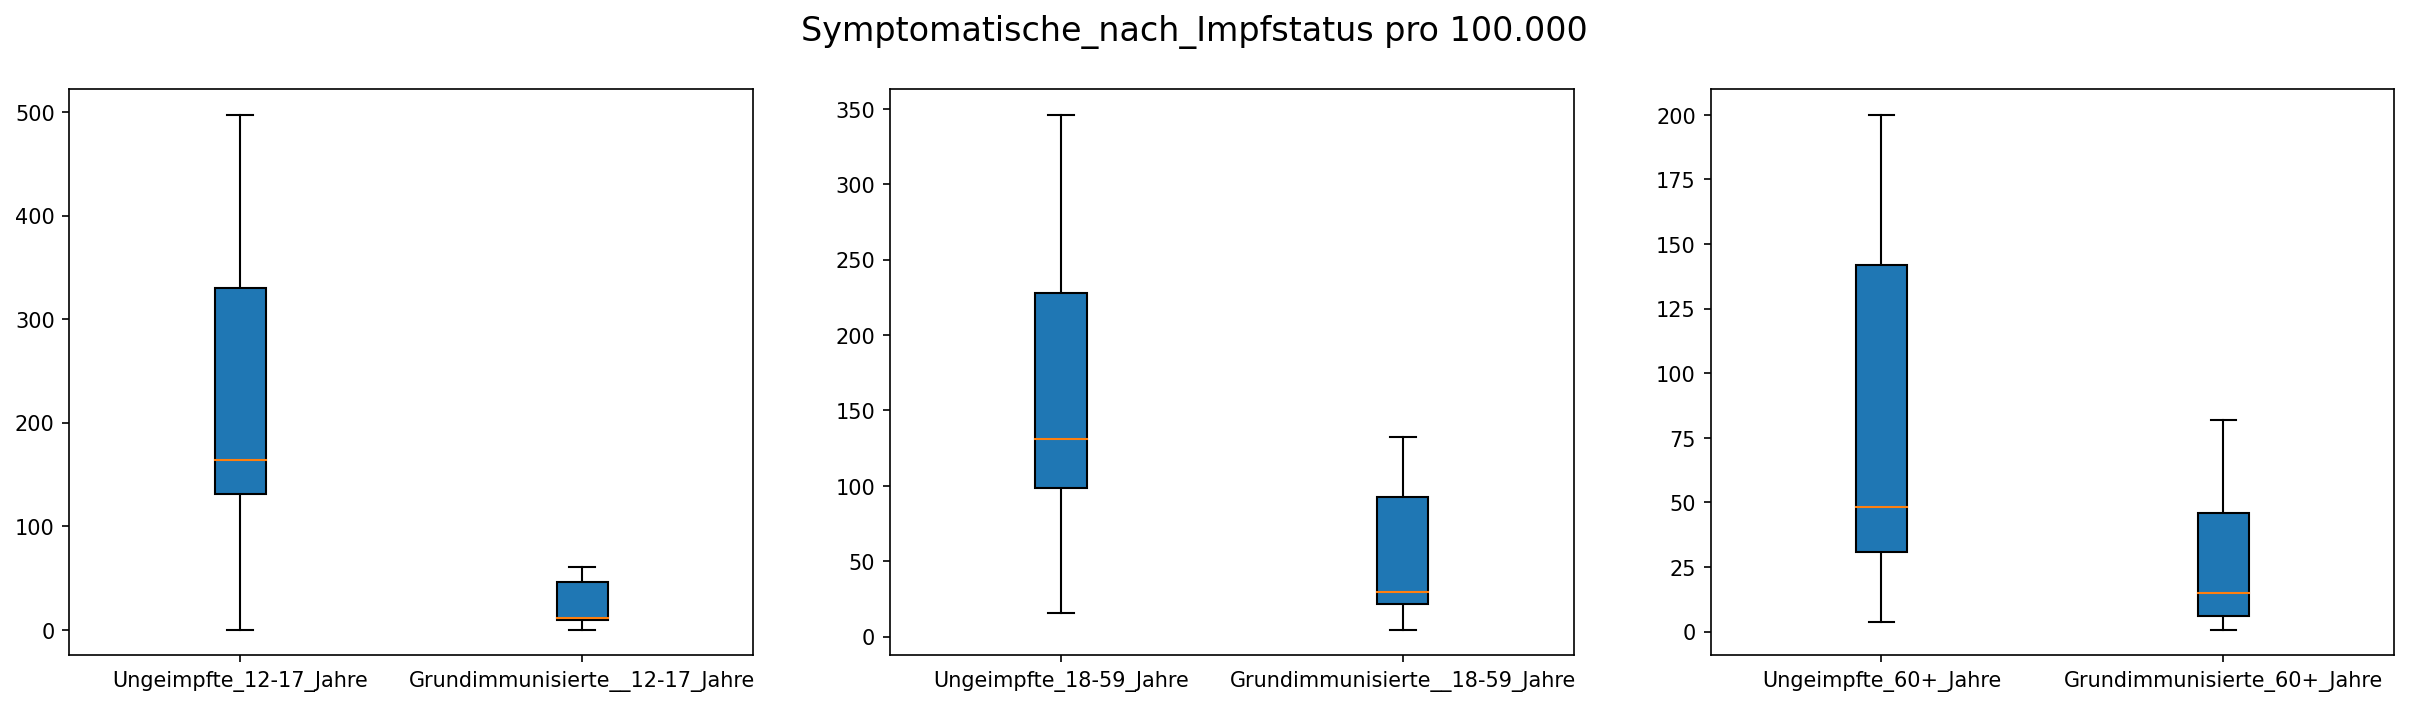

In [7]:
fig, axes = plt.subplots(1,3,figsize=(20,5),dpi=150,)
fig.suptitle('Symptomatische_nach_Impfstatus pro 100.000', fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.boxplot([da1[symp[i][0]],da1[symp[i][1]]],patch_artist=True,labels=[symp[i][0],symp[i][1]])

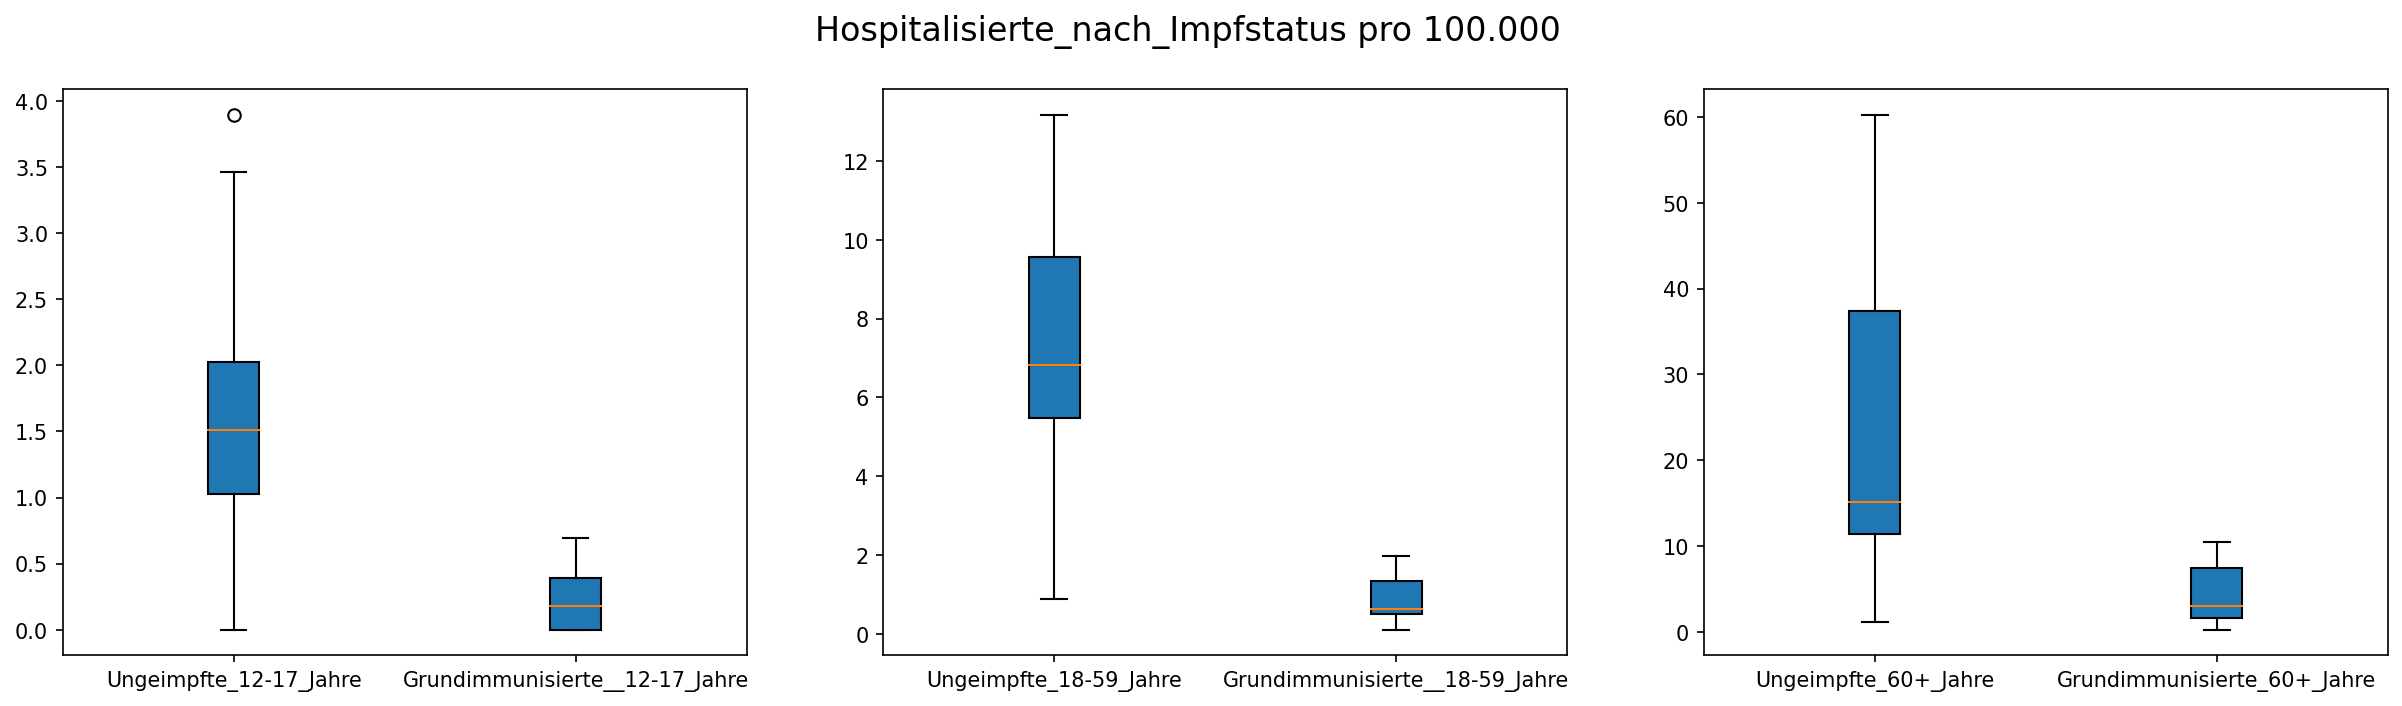

In [8]:
fig, axes = plt.subplots(1,3,figsize=(20,5),dpi=150,)
fig.suptitle('Hospitalisierte_nach_Impfstatus pro 100.000', fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.boxplot([da2[hosp[i][0]],da2[hosp[i][1]]],patch_artist=True,labels=[hosp[i][0],hosp[i][1]])

## Hypothesis-testing:
- To check if vaccines are effective, I want to compare means of groups where one is vaccinated and the other is not
- group1 contains the unvaccinated, group2 the vaccinated
- so I choose H0,H1:
$$
H_0: \mu_1 - \mu_2 \le 0
$$
$$
H_1: \mu_1 - \mu_2 > 0
$$

- H_0 is the hypothesis that vaccines doesnt or negativly effect hopsilisation/getting sypmtoms from an infection


# Tried to use the 2 sample t-Test, with bootstrap
- both samples are independend (ignoring time)
- simulated t distribution with bootstrap
- had to look up how to do it with source:
- https://stats.stackexchange.com/questions/92542/how-to-perform-a-bootstrap-test-to-compare-the-means-of-two-samples
- https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Bootstrap_hypothesis_testing

In [9]:
sample1=da1[hosp[2][0]]
sample2=da1[hosp[2][1]]

#1.
def tstatistic (sample1,sample2):
    sd1=sample1.std()
    sd2=sample2.std()
    n=sample1.size
    m=sample2.size
    mean1=sample1.mean()
    mean2=sample2.mean()
    return(math.sqrt((n*m)/(n+m))*(mean1-mean2)/(math.sqrt((1/2)*(sd1**2+sd2**2))))
#2.
both_samples = np.concatenate((sample1, sample2))
mean_both=both_samples.mean()
sample1_diff=sample1-sample1.mean()+mean_both
sample2_diff=sample2-sample2.mean()+mean_both
#3.-5.
t_values=[]
for _ in tqdm(range(10000)):
    resample1 = np.random.choice(sample1_diff, size=len(sample1), replace=True)
    resample2 = np.random.choice(sample2_diff, size=len(sample2), replace=True)
    t_values.append(tstatistic(resample1,resample2))
#6.
print("pval=",(np.array(t_values)>=tstatistic(sample1,sample2)).mean())    

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6566.54it/s]

pval= 0.0004


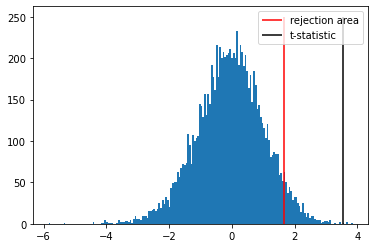

In [10]:
plt.hist(t_values,bins=180)
plt.vlines(np.quantile(t_values,.95),0,250,color="r",label="rejection area")
plt.vlines(tstatistic(sample1,sample2),0,250,color="black",label="t-statistic")
plt.legend()

In [11]:
tstatistic(sample1,sample2)

3.543688868350816

In [12]:
stats.ttest_ind(sample1,sample2)

Ttest_indResult(statistic=3.5436888683508156, pvalue=0.0008908630202030606)

## Decision: Doing the test for every group I can reject the null hypothesis with a very low p value (most of the times its just 0 becouse its probably too small) and also because the t statistic is far in the rejection area.

# Permutationtest where:
$$
H_0: \mu_1 - \mu_2 = 0
$$
$$
H_1: \mu_1 - \mu_2 > 0
$$
- i assume here that vaccination doesnt effect sympt/hops negative so I can perform Permutation-test
bootstrapping:

In [13]:
sample1=da1[hosp[2][0]]
sample2=da1[hosp[2][1]]
np.random.seed(42)

both_samples = np.concatenate((sample1, sample2))

diffs_of_means = []
for _ in tqdm(range(100000)):
    
    # creating a new sample from each population by shuffling the labels
    
    resample = np.random.choice(both_samples, size=len(both_samples), replace=False)
    resample1 = resample[:len(sample1)]
    resample2 = resample[len(sample1):]
    
    diff_of_means = resample1.mean() - resample2.mean()
    diffs_of_means.append(diff_of_means)


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 23457.71it/s]


Compute P-Value


In [14]:
null_mean = 0
abs_sample_diff_of_means = np.abs(sample1.mean() - sample2.mean())
abs_sample_diff_of_means

51.28831258773804

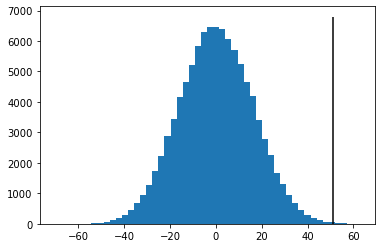

In [15]:
fig, ax = plt.subplots()

ax.hist(diffs_of_means, bins=50);
ylim = ax.get_ylim()
ax.vlines(null_mean + abs_sample_diff_of_means, *ylim, color='k')

In [16]:
(np.array(diffs_of_means) >= null_mean + abs_sample_diff_of_means).mean()

0.00035

## I would reject the null hypothesis here aswell

# Hypothesis test on vaccinated vs boostered
- group1 contains the vaccinated, group2 the boostered
- so I choose H0,H1:
$$
H_0: \mu_1 - \mu_2 \le 0
$$
$$
H_1: \mu_1 - \mu_2 > 0
$$

In [17]:
da1=df1.iloc[14:,[5,6,8,9]]
da2=df2.iloc[14:,[5,6,8,9]]
symp=np.array_split(np.array(da1.columns),2)
hosp=np.array_split(np.array(da2.columns),2)

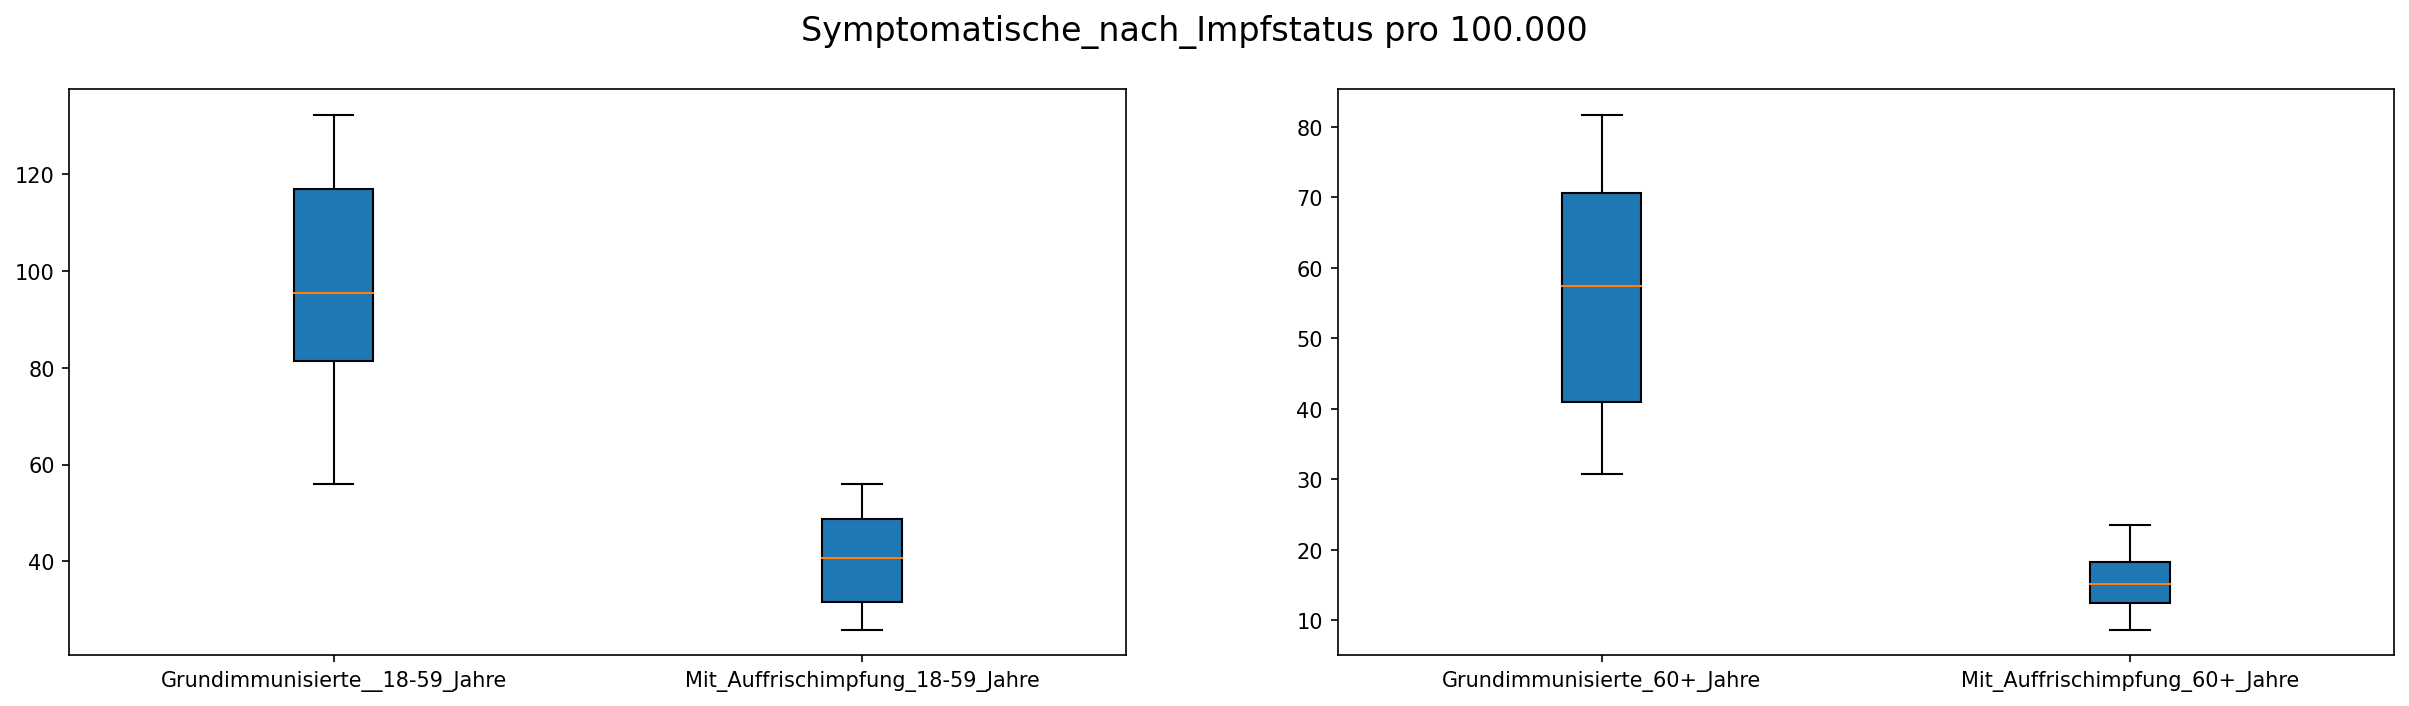

In [18]:
fig, axes = plt.subplots(1,2,figsize=(20,5),dpi=150,)
fig.suptitle('Symptomatische_nach_Impfstatus pro 100.000', fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.boxplot([da1[symp[i][0]],da1[symp[i][1]]],patch_artist=True,labels=[symp[i][0],symp[i][1]])

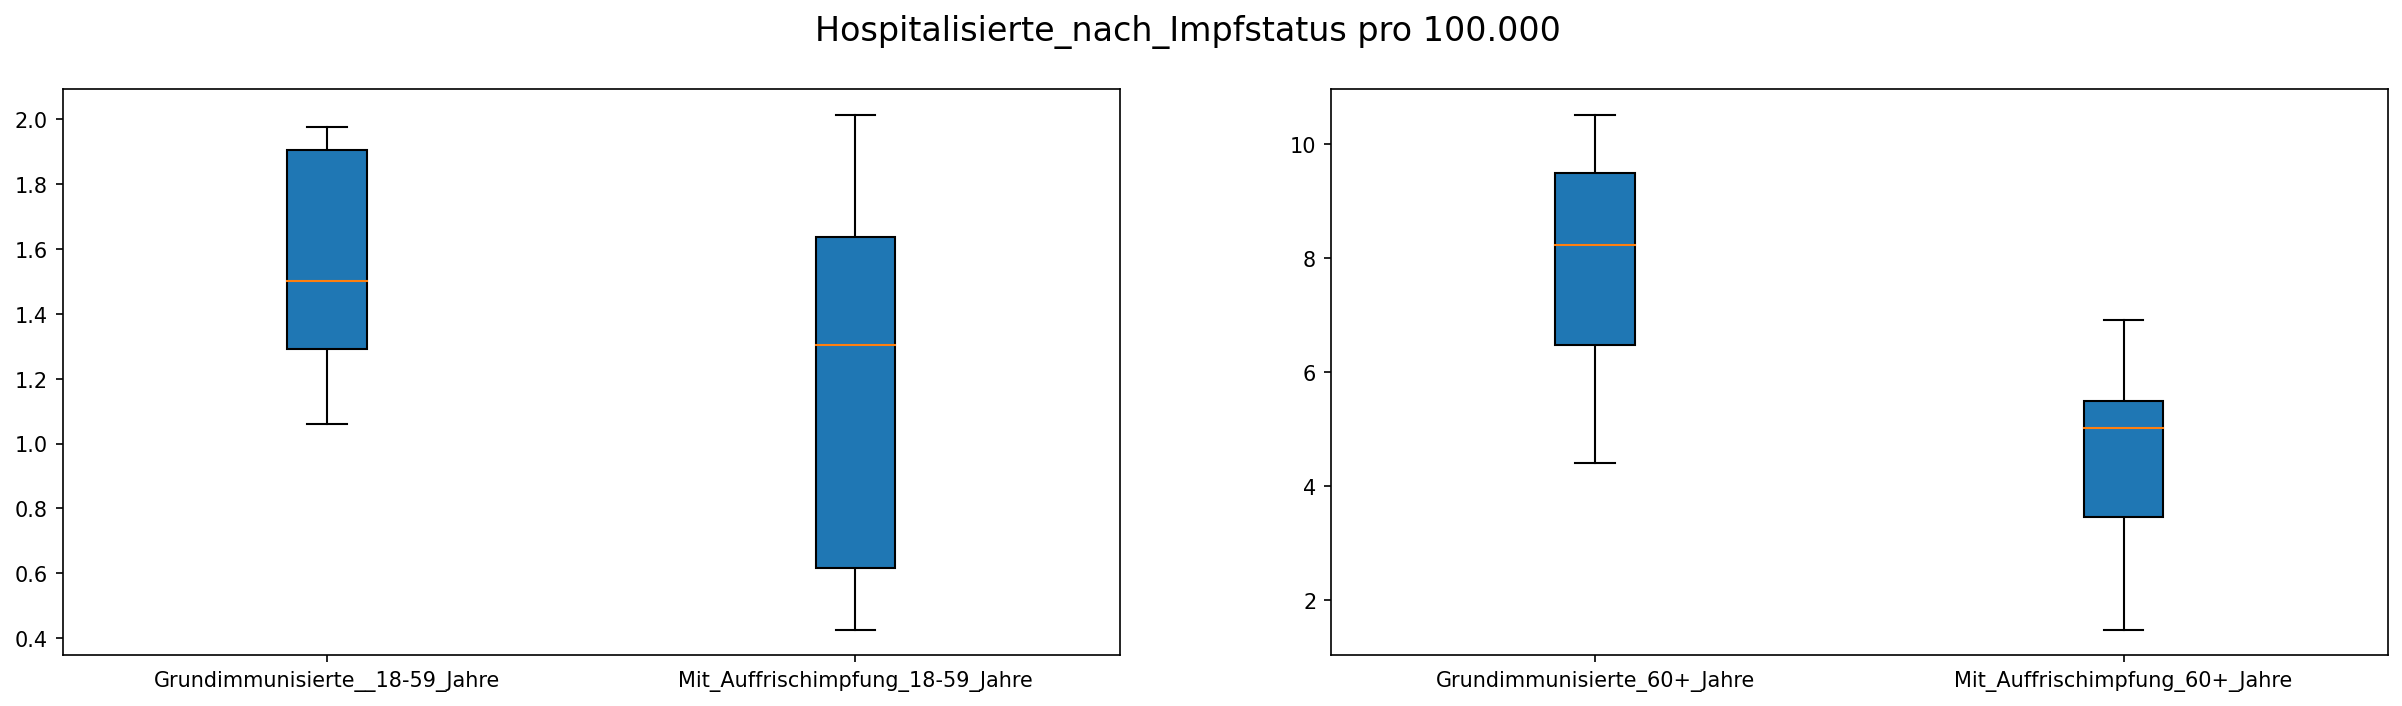

In [19]:
fig, axes = plt.subplots(1,2,figsize=(20,5),dpi=150,)
fig.suptitle('Hospitalisierte_nach_Impfstatus pro 100.000', fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.boxplot([da2[hosp[i][0]],da2[hosp[i][1]]],patch_artist=True,labels=[hosp[i][0],hosp[i][1]])

In [20]:
sample1=da2[symp[0][0]]
sample2=da2[symp[0][1]]

#1.
def tstatistic (sample1,sample2):
    sd1=sample1.std()
    sd2=sample2.std()
    n=sample1.size
    m=sample2.size
    mean1=sample1.mean()
    mean2=sample2.mean()
    return(math.sqrt((n*m)/(n+m))*(mean1-mean2)/(math.sqrt((1/2)*(sd1**2+sd2**2))))
#2.
both_samples = np.concatenate((sample1, sample2))
mean_both=both_samples.mean()
sample1_diff=sample1-sample1.mean()+mean_both
sample2_diff=sample2-sample2.mean()+mean_both
#3.-5.
t_values=[]
for _ in tqdm(range(20000)):
    resample1 = np.random.choice(sample1_diff, size=len(sample1), replace=True)
    resample2 = np.random.choice(sample2_diff, size=len(sample2), replace=True)
    t_values.append(tstatistic(resample1,resample2))
#6.
print("pval=",(np.array(t_values)>=tstatistic(sample1,sample2)).mean())    

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 6456.22it/s]

pval= 0.04735


## I would reject the null hypothesis as well and say that people with boostered are protected better for hospitilization and getting symptoms

# Question 2: What is the effect of non-pharmaceutical measures (e.g. lockdowns)?


## Plotting Data: 
- Data Source: https://ourworldindata.org/explorers/coronavirus-data-explorer?zoomToSelection=true&time=2020-03-01..latest&facet=none&pickerSort=asc&pickerMetric=location&Metric=Confirmed+cases&Interval=7-day+rolling+average&Relative+to+Population=true&Color+by+test+positivity=false&country=USA~GBR~CAN~DEU~ITA~IND
-https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_Deutschland#Bundesweite_Infektionsschutzma%C3%9Fnahmen

In [7]:
#interested in data from germany
df=pd.read_csv("Q12.csv")
iso=df.groupby(df.iso_code)
deu=iso.get_group("DEU")
deu["date"]=pd.to_datetime(deu["date"])
deu=deu.set_index('date')

<ipython-input-7-72eb753edc5b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deu["date"]=pd.to_datetime(deu["date"])


- Inzidenz (New cases over last 7 days per 100k)

In [8]:
deu_in = deu[["new_cases"]]
faelle=deu_in.to_numpy() 

In [9]:
siebeninz=[0,0,0,0,0,0]
for ind in range(6,714):
    summ=sum(faelle[ind-6:ind+1])
    summ=summ*(100000/83900471)
    siebeninz.append(summ)
deu["inz"]=siebeninz

- A way to sharpen the question is to test if the 7-days inzidenz(or other values) trend decreased significant after measures vs. before
- for that i could splut the sample into two (one before one after) and put a lin regression on it and compare the slopes

- The only idea to test if the measure is effective is to comprare trends before and after the measure, because taking the mean wouldnt provide a good answer
(e.g. if the graph in the interval is symmetric)
- the trends would be the slopes of a regression for the data
- variants of virus which could effect the variables are ignored

Split into 2 groups
- group 1: the month before 1 week after measure
- group2: month after 1 week after measure

In [10]:
import sklearn
from sklearn import linear_model

In [16]:
sample1=[]
sample2=[]

<ipython-input-17-8981d3ab14f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['days_from_start'] = (group1.index - group1.index[0]).days
<ipython-input-17-8981d3ab14f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['days_from_start'] = (group2.index - group2.index[0]).days


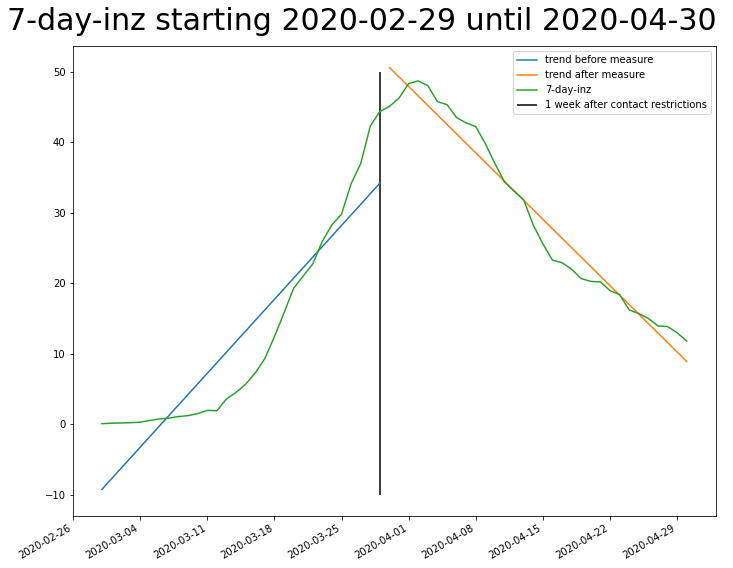

In [17]:
group=deu['2020-02-29':"2020-04-30"]
group1=deu['2020-02-29' :'2020-03-29']
group2=deu["2020-03-30":"2020-04-30"]
group1['days_from_start'] = (group1.index - group1.index[0]).days
group2['days_from_start'] = (group2.index - group2.index[0]).days


x1 = group1['days_from_start'].values.reshape(-1, 1)
y1=group1["inz"].fillna(0).values
x2 = group2['days_from_start'].values.reshape(-1, 1)
y2=group2["inz"].fillna(0).values
model1 = linear_model.LinearRegression().fit(x1, y1)
linear_model.LinearRegression(fit_intercept=True)
model2 = linear_model.LinearRegression().fit(x2, y2)
linear_model.LinearRegression(fit_intercept=True)

sample1.append(model1.coef_[0])
sample2.append(model2.coef_[0])

fig,ax1=plt.subplots(figsize=(10,8))
ax1.plot(group1.index,x1*model1.coef_+model1.intercept_,label="trend before measure")
ax1.plot(group2.index,x2*model2.coef_+model2.intercept_,label="trend after measure")
ax1.plot(group.index,group["inz"],label="7-day-inz")
ax1.vlines(pd.to_datetime("2020-03-29"),-10,50,label="1 week after contact restrictions",color="black")
ax1.legend()
fig.suptitle("7-day-inz starting 2020-02-29 until 2020-04-30 ",fontsize=30)
fig.autofmt_xdate()
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.tight_layout()

<ipython-input-18-cc6c574865e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['days_from_start'] = (group1.index - group1.index[0]).days
<ipython-input-18-cc6c574865e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['days_from_start'] = (group2.index - group2.index[0]).days


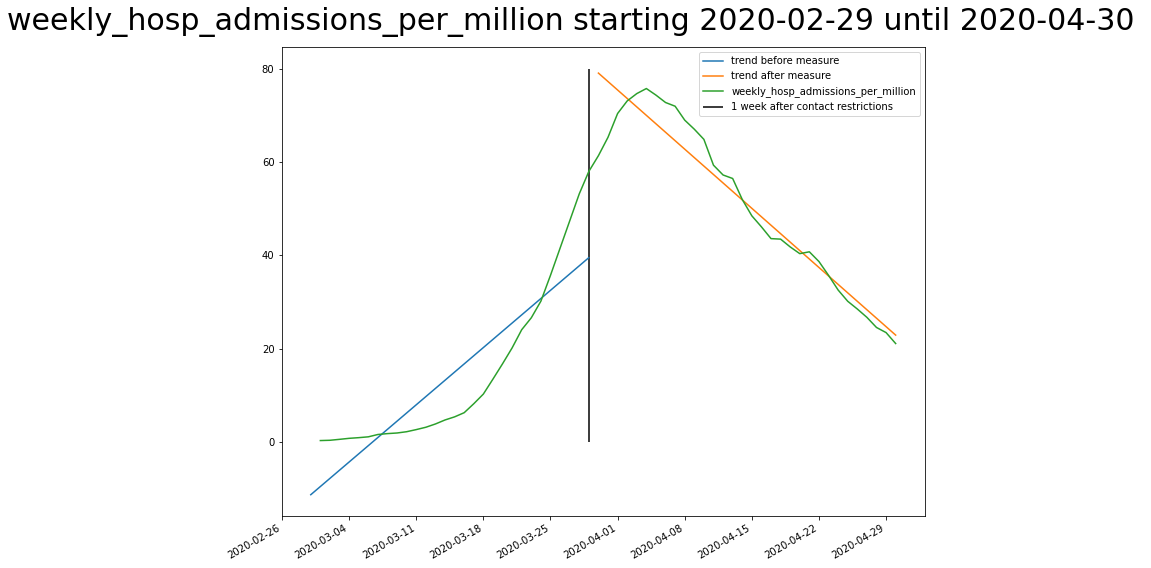

In [18]:
group=deu['2020-02-29':"2020-04-30"]
group1=deu['2020-02-29' :'2020-03-29']
group2=deu["2020-03-30":"2020-04-30"]
group1['days_from_start'] = (group1.index - group1.index[0]).days
group2['days_from_start'] = (group2.index - group2.index[0]).days


x1 = group1['days_from_start'].values.reshape(-1, 1)
y1=group1["weekly_hosp_admissions_per_million"].fillna(0).values
x2 = group2['days_from_start'].values.reshape(-1, 1)
y2=group2["weekly_hosp_admissions_per_million"].fillna(0).values
model3 = linear_model.LinearRegression().fit(x1, y1)
linear_model.LinearRegression(fit_intercept=True)
model4 = linear_model.LinearRegression().fit(x2, y2)
linear_model.LinearRegression(fit_intercept=True)
#add to slopes array
sample1.append(model3.coef_[0])
sample2.append(model4.coef_[0])

fig,ax1=plt.subplots(figsize=(10,8))
ax1.plot(group1.index,x1*model3.coef_+model3.intercept_,label="trend before measure")
ax1.plot(group2.index,x2*model4.coef_+model4.intercept_,label="trend after measure")
ax1.plot(group.index,group["weekly_hosp_admissions_per_million"],label="weekly_hosp_admissions_per_million")
ax1.vlines(pd.to_datetime("2020-03-29"),0,80,label="1 week after contact restrictions",color="black")
ax1.legend()

fig.suptitle("weekly_hosp_admissions_per_million starting 2020-02-29 until 2020-04-30 ",fontsize=30)
fig.autofmt_xdate()
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.tight_layout()

<ipython-input-19-fe722c33a051>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['days_from_start'] = (group1.index - group1.index[0]).days
<ipython-input-19-fe722c33a051>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['days_from_start'] = (group2.index - group2.index[0]).days


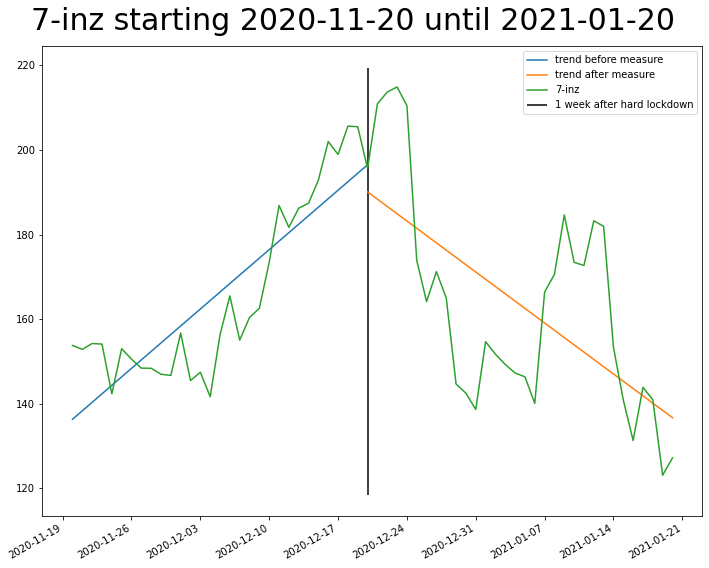

In [19]:
group=deu['2020-11-20':"2021-01-20"]
group1=deu['2020-11-20' :'2020-12-20']
group2=deu["2020-12-20":"2021-01-20"]
group1['days_from_start'] = (group1.index - group1.index[0]).days
group2['days_from_start'] = (group2.index - group2.index[0]).days


x1 = group1['days_from_start'].values.reshape(-1, 1)
y1=group1["inz"].fillna(0).values
x2 = group2['days_from_start'].values.reshape(-1, 1)
y2=group2["inz"].fillna(0).values
model3 = linear_model.LinearRegression().fit(x1, y1)
linear_model.LinearRegression(fit_intercept=True)
model4 = linear_model.LinearRegression().fit(x2, y2)
linear_model.LinearRegression(fit_intercept=True)
#add to slopes array
sample1.append(model3.coef_[0])
sample2.append(model4.coef_[0])
fig,ax1=plt.subplots(figsize=(10,8))
ax1.plot(group1.index,x1*model3.coef_+model3.intercept_,label="trend before measure")
ax1.plot(group2.index,x2*model4.coef_+model4.intercept_,label="trend after measure")
ax1.plot(group.index,group["inz"],label="7-inz")
ylim = ax1.get_ylim()
ax1.vlines(pd.to_datetime("2020-12-20"),*ylim,label="1 week after hard lockdown",color="black")
ax1.legend()

fig.suptitle("7-inz starting 2020-11-20 until 2021-01-20",fontsize=30)
fig.autofmt_xdate()
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.tight_layout()

<ipython-input-20-010df026fa2c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['days_from_start'] = (group1.index - group1.index[0]).days
<ipython-input-20-010df026fa2c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['days_from_start'] = (group2.index - group2.index[0]).days


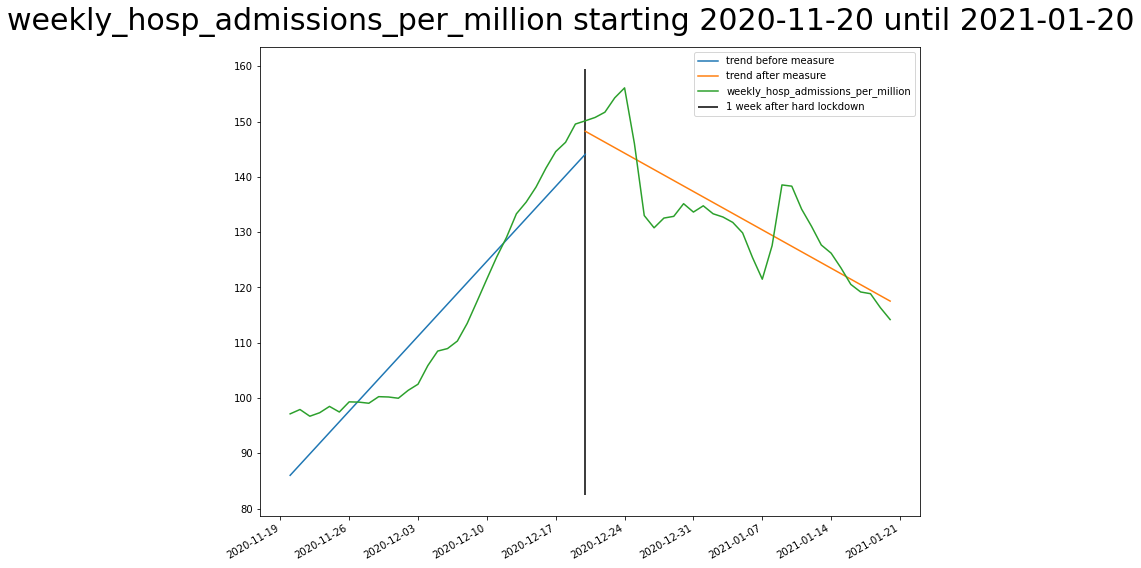

In [20]:
group=deu['2020-11-20':"2021-01-20"]
group1=deu['2020-11-20' :'2020-12-20']
group2=deu["2020-12-20":"2021-01-20"]
group1['days_from_start'] = (group1.index - group1.index[0]).days
group2['days_from_start'] = (group2.index - group2.index[0]).days


x1 = group1['days_from_start'].values.reshape(-1, 1)
y1=group1["weekly_hosp_admissions_per_million"].fillna(0).values
x2 = group2['days_from_start'].values.reshape(-1, 1)
y2=group2["weekly_hosp_admissions_per_million"].fillna(0).values
model3 = linear_model.LinearRegression().fit(x1, y1)
linear_model.LinearRegression(fit_intercept=True)
model4 = linear_model.LinearRegression().fit(x2, y2)
linear_model.LinearRegression(fit_intercept=True)
#add to slopes array
sample1.append(model3.coef_[0])
sample2.append(model4.coef_[0])

fig,ax1=plt.subplots(figsize=(10,8))
ax1.plot(group1.index,x1*model3.coef_+model3.intercept_,label="trend before measure")
ax1.plot(group2.index,x2*model4.coef_+model4.intercept_,label="trend after measure")
ax1.plot(group.index,group["weekly_hosp_admissions_per_million"],label="weekly_hosp_admissions_per_million")
ylim = ax1.get_ylim()
ax1.vlines(pd.to_datetime("2020-12-20"),*ylim,label="1 week after hard lockdown",color="black")
ax1.legend()

fig.suptitle("weekly_hosp_admissions_per_million starting 2020-11-20 until 2021-01-20",fontsize=30)
fig.autofmt_xdate()
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.tight_layout()

<ipython-input-21-f6b8d2878f0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['days_from_start'] = (group1.index - group1.index[0]).days
<ipython-input-21-f6b8d2878f0b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['days_from_start'] = (group2.index - group2.index[0]).days


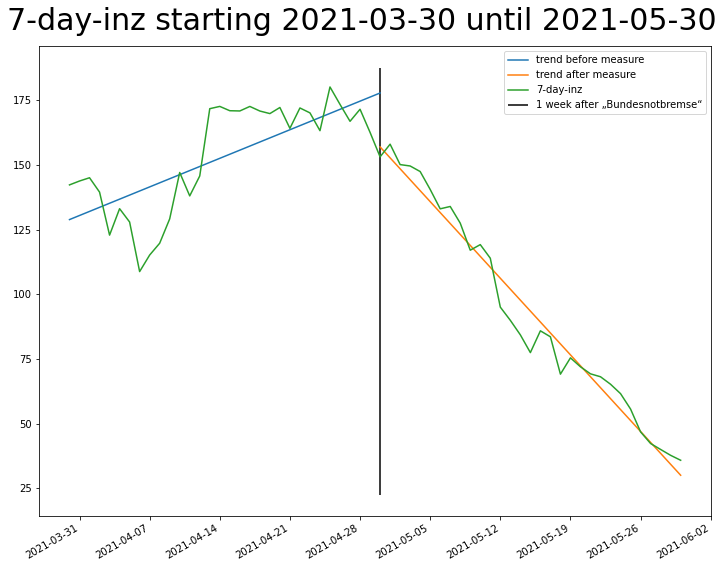

In [21]:
#Bundesnotbremse 23.4
group=deu['2021-03-30':"2021-05-30"]
group1=deu['2021-03-30' :'2021-04-30']
group2=deu["2021-04-30":"2021-05-30"]
group1['days_from_start'] = (group1.index - group1.index[0]).days
group2['days_from_start'] = (group2.index - group2.index[0]).days


x1 = group1['days_from_start'].values.reshape(-1, 1)
y1=group1["inz"].fillna(0).values
x2 = group2['days_from_start'].values.reshape(-1, 1)
y2=group2["inz"].fillna(0).values
model1 = linear_model.LinearRegression().fit(x1, y1)
linear_model.LinearRegression(fit_intercept=True)
model2 = linear_model.LinearRegression().fit(x2, y2)
linear_model.LinearRegression(fit_intercept=True)
sample1.append(model1.coef_[0])
sample2.append(model2.coef_[0])

fig,ax1=plt.subplots(figsize=(10,8))
ax1.plot(group1.index,x1*model1.coef_+model1.intercept_,label="trend before measure")
ax1.plot(group2.index,x2*model2.coef_+model2.intercept_,label="trend after measure")
ax1.plot(group.index,group["inz"],label="7-day-inz")
ylim = ax1.get_ylim()
ax1.vlines(pd.to_datetime("2021-04-30"),*ylim,label="1 week after „Bundesnotbremse“",color="black")
ax1.legend()
fig.suptitle("7-day-inz starting 2021-03-30 until 2021-05-30",fontsize=30)
fig.autofmt_xdate()
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.tight_layout()

<ipython-input-22-7306f1f9613e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['days_from_start'] = (group1.index - group1.index[0]).days
<ipython-input-22-7306f1f9613e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['days_from_start'] = (group2.index - group2.index[0]).days


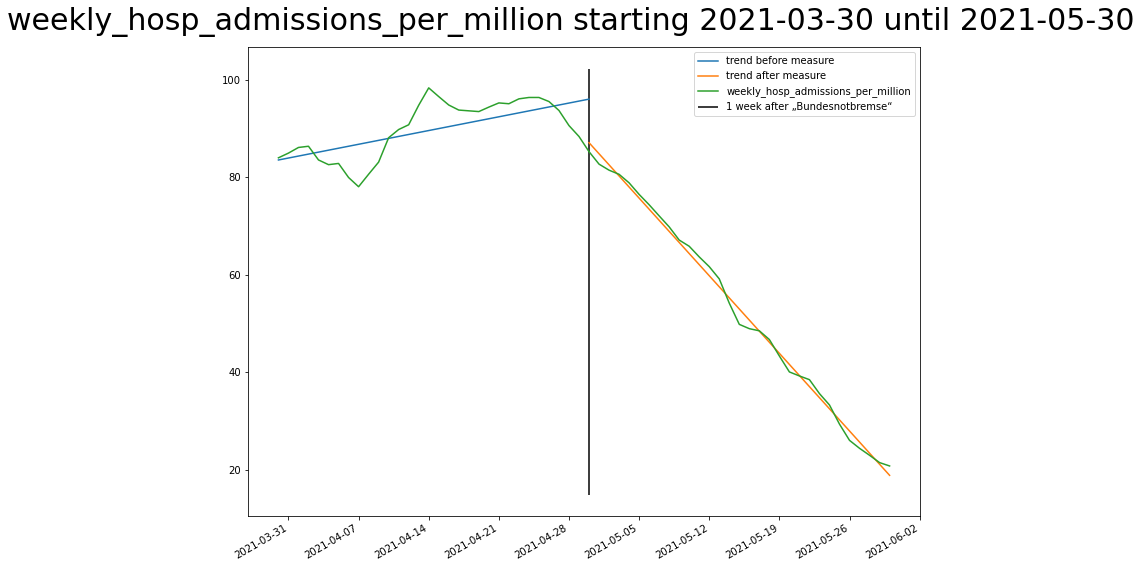

In [22]:
#Bundesnotbremse 23.4
group=deu['2021-03-30':"2021-05-30"]
group1=deu['2021-03-30' :'2021-04-30']
group2=deu["2021-04-30":"2021-05-30"]
group1['days_from_start'] = (group1.index - group1.index[0]).days
group2['days_from_start'] = (group2.index - group2.index[0]).days


x1 = group1['days_from_start'].values.reshape(-1, 1)
y1=group1["weekly_hosp_admissions_per_million"].fillna(0).values
x2 = group2['days_from_start'].values.reshape(-1, 1)
y2=group2["weekly_hosp_admissions_per_million"].fillna(0).values
model1 = linear_model.LinearRegression().fit(x1, y1)
linear_model.LinearRegression(fit_intercept=True)
model2 = linear_model.LinearRegression().fit(x2, y2)
linear_model.LinearRegression(fit_intercept=True)
sample1.append(model1.coef_[0])
sample2.append(model2.coef_[0])

fig,ax1=plt.subplots(figsize=(10,8))
ax1.plot(group1.index,x1*model1.coef_+model1.intercept_,label="trend before measure")
ax1.plot(group2.index,x2*model2.coef_+model2.intercept_,label="trend after measure")
ax1.plot(group.index,group["weekly_hosp_admissions_per_million"],label="weekly_hosp_admissions_per_million")
ylim = ax1.get_ylim()
ax1.vlines(pd.to_datetime("2021-04-30"),*ylim,label="1 week after „Bundesnotbremse“",color="black")
ax1.legend()
fig.suptitle("weekly_hosp_admissions_per_million starting 2021-03-30 until 2021-05-30",fontsize=30)
fig.autofmt_xdate()
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.tight_layout()

## Hypothesis-testing:
- To check if measures are effective, I want to compare means of groups where one is before and the other is after measure
- group1 contains before, group2 after
- so I choose H0,H1:
$$
H_0: \mu_1 - \mu_2 \le 0
$$
$$
H_1: \mu_1 - \mu_2 > 0
$$

- H_0 is the hypothesis that measure doesnt or negatively effects some parameters
- use two sample dependend t test

In [23]:
sample1=np.array(sample1)
sample2=np.array(sample2)
sample1

array([1.4983769 , 1.75149989, 2.00545752, 1.93626129, 1.57915407,
       0.40293292])

In [24]:
#1.
def tstatistic_dependend (sample1,sample2):
    n=sample1.size
    diff=sample1-sample2
    d_bar=diff.mean()
    d_1=np.square(diff-d_bar)
    d_2=np.sum(d_1)
    d_3=math.sqrt(d_2/(n-1))
    return(math.sqrt(n)*d_bar/d_3)
#2.
both_samples = np.concatenate((sample1, sample2))
mean_both=both_samples.mean()
sample1_diff=sample1-sample1.mean()+mean_both
sample2_diff=sample2-sample2.mean()+mean_both
#3.-5.
t_values=[]
for _ in tqdm(range(10000)):
    resample1 = np.random.choice(sample1_diff, size=len(sample1), replace=True)
    resample2 = np.random.choice(sample2_diff, size=len(sample2), replace=True)
    t_values.append(tstatistic_dependend(resample1,resample2))
#6.
print("pval=",(np.array(t_values)>=tstatistic_dependend(sample1,sample2)).mean())    

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8694.28it/s]

pval= 0.0


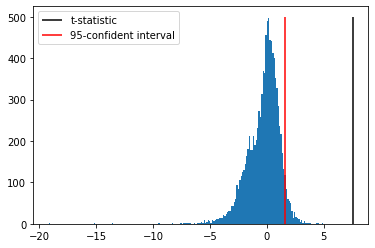

In [25]:
plt.hist(t_values,bins=200)
plt.vlines(tstatistic_dependend(sample1,sample2),0,500,label="t-statistic",color="black")
plt.vlines(np.percentile(t_values, 95),0,500,label="95-confident interval",color="red")
plt.legend()